In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
upload = files.upload()

Saving dano_dataset_avia_hashed_corrected_s.xlsx to dano_dataset_avia_hashed_corrected_s.xlsx


In [ ]:
import io
avia_df = pd.read_excel(io.BytesIO(upload['dano_dataset_avia_hashed_corrected_s.xlsx']))

# Минимальные сведения о данных
Количество пропущенных и нулевых значений в таблице и где именно они находятся.

In [ ]:
avia_df.isnull().sum()

,0
session_start_dt,0
device_platform,211
client_start_year,45
client_id,0
session_id,0
session_source,0
session_channel,0
screen_nm,0
screen_dttm,0
client_avia_user_start_year,0


Общее количество действий.

In [ ]:
print(avia_df['session_id'].count())

244345


Количество уникальных сессий.

In [ ]:
avia_df['session_id'].nunique()

38561

Количество клиентов.

In [ ]:
avia_df['client_id'].nunique()

1900

# Подготовка и анализ данных для исследования воронки
Рассмотрим количество действий, которые пользователь совершает на каждом этапе воронки

In [ ]:
avia_cnv = avia_df['screen_nm'].value_counts()
avia_cnv

,count
screen_nm,
Выдача,110591
Поиск,59525
Оффер,53172
Чекаут,15836
Покупка бэк,2789
Покупка фронт,2432


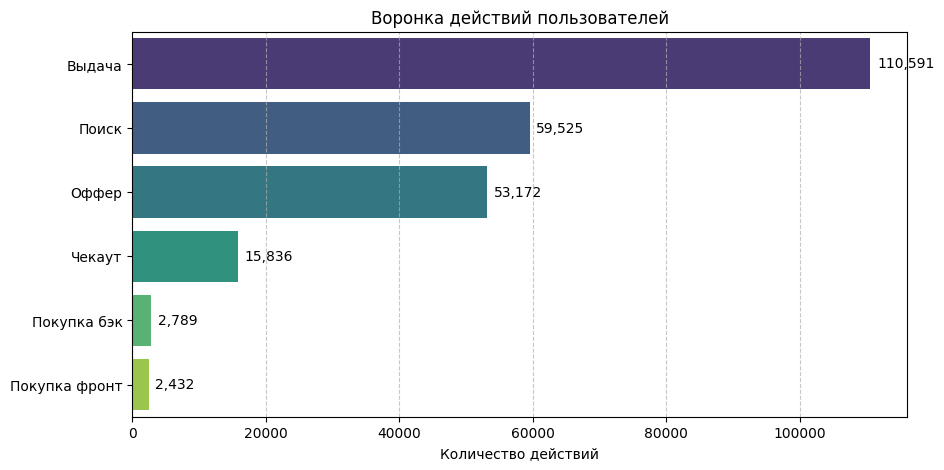

In [ ]:
plt.figure(figsize=(10, 5))
avia_cnv_df = avia_cnv.reset_index()
avia_cnv_df.columns = ['step', 'cnt']

sns.barplot(
    x='cnt',
    y='step',
    data=avia_cnv_df,
    palette='viridis',
    hue='step',
    legend=False
)

for index, row in avia_cnv_df.iterrows():
    plt.text(row.cnt + 1000, index, f'{row.cnt:,}', color='black', ha="left", va="center")

plt.title('Воронка действий пользователей')
plt.xlabel('Количество действий')
plt.ylabel('')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Отсюда можно увидеть, что больше всего действий пользователь совершает именно на втором этапе воронки - то есть на экране Выдачи, где получает основную инфомацию о билетах. Экран Выдача является основным этапом, где пользователь принимает решение, именно там выбирает варианты, сравнивает цены, применяет фильтры. Поэтому можем рассмотреть пользовательский сценарий, который будет предполагать в себе Выдачу->Оффер->Чекаут->Количество успешных статусов покупки. Что и будет воронкой, по которой уже можно делать выводы о конверсии к продаже.

In [ ]:
funnel_step_value = {'Выдача':1,'Оффер':2,'Чекаут':3}

avia_df['funnel_step'] = avia_df['screen_nm'].map(funnel_step_value)

session_max_step = avia_df.groupby('session_id', as_index=False)['funnel_step'].max()

purchase_sessions = avia_df.query('session_purchase_status == "Успешные"')['session_id'].unique()

session_max_step['purchase_flg'] = session_max_step['session_id'].isin(purchase_sessions)

funnel_sessions = []

for step_name, step_value in funnel_step_value.items():
    cnt = session_max_step.query('funnel_step >= @step_value')['session_id'].nunique()
    funnel_sessions.append([step_name, cnt])

purchase_cnt = session_max_step['purchase_flg'].sum()

funnel_sessions.append(['Успешная покупка', purchase_cnt])

funnel_df = pd.DataFrame(funnel_sessions,columns=['step', 'sessions_cnt'])

funnel_df

,step,sessions_cnt
0,Выдача,34380
1,Оффер,17776
2,Чекаут,6469
3,Успешная покупка,2364


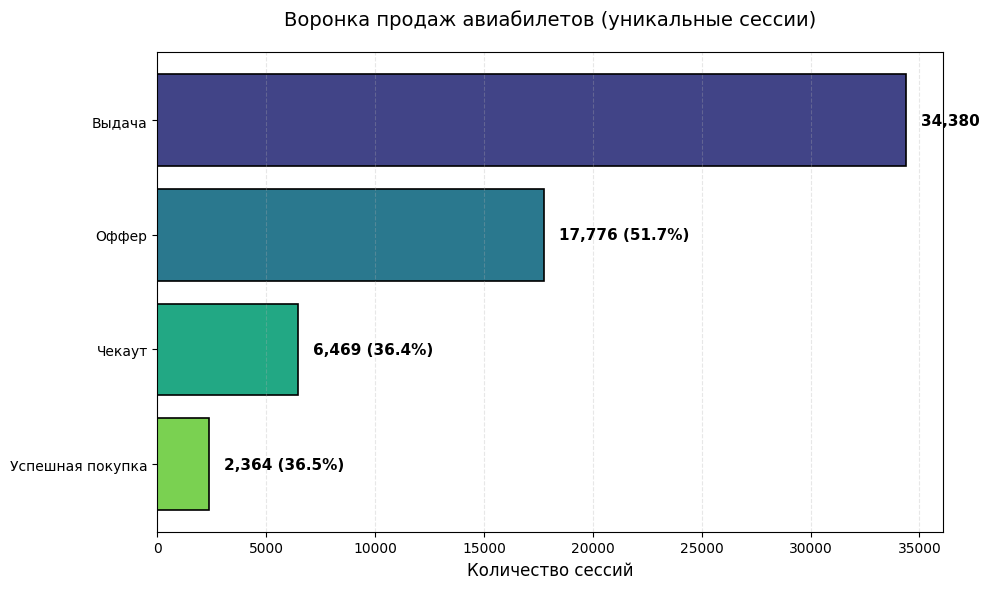

In [ ]:
funnel_df.columns = ['Этап', 'Сессии']

funnel_df['Конверсия от предыдущего этапа, %'] = (
    funnel_df['Сессии'] / funnel_df['Сессии'].shift(1) * 100
).round(1)

plt.figure(figsize=(10, 6))

colors = sns.color_palette("viridis", len(funnel_df))
bars = plt.barh(
    funnel_df['Этап'],
    funnel_df['Сессии'],
    color=colors,
    edgecolor='black',
    linewidth=1.2
)

for i, (idx, row) in enumerate(funnel_df.iterrows()):
    conv_prev_step = row['Конверсия от предыдущего этапа, %']
    conversion_text = f" ({conv_prev_step:.1f}%) " if pd.notna(conv_prev_step) else ""
    plt.text(
        row['Сессии'] + funnel_df['Сессии'].max() * 0.02,
        i,
        f"{row['Сессии']:,}{conversion_text}",
        va='center',
        fontsize=11,
        fontweight='bold'
    )

plt.gca().invert_yaxis()
plt.title('Воронка продаж авиабилетов (уникальные сессии)', fontsize=14, pad=20)
plt.xlabel('Количество сессий', fontsize=12)
plt.ylabel('')
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

Заметим, что с этапа Выдачи до этапа Чекаут доходит ~1/6 часть сессий, поэтому предположим гипотезы, которые могут повлиять на продажную конверсию и конверсию между определенными этапами.

# Гипотеза 1
## Если пользователю на этапе Выдачи  предложить два специальных предложения - самый дешевый рейс и самый быстрый рейс на выбранные даты, то конверсия из этапа Оффера в этап Чекаут увеличится, за счёт увеличения качества Офферов и упрощения выбора.

Вторая гипотеза направлена на то, чтобы удержать пользователя на этапе Оффера.

# Гипотеза 2

## Если пользователя на этапе Оффера информировать о более выгодных датах перелёта в ближайший период(+-2-3 дня), то конверсия из этапа Выдачи в этап Успешной покупки увеличится, за счёт удержания пользователя на этапе Оффера.

Третья гипотеза направлена на сокращение времени выбора на этапе Оффера.

# Гипотеза 3
## Если пользователю на этапе Оффера сообщать о том, что "Осталось мало билетов"("Билеты скоро кончатся"), то конверсия из этапа Оффера в этап Чекаут увеличится, за счёт уменьшения неопределённости при выборе.

# Дизайн Эксперимента
Флоу по которому будет происходить дизайн:
1.   Формулирование бизнес-гипотезы
2.   Выбор метрик
3.   Формулирование статистической гипотезы
4.   Выбор статистического критерия
5.   Определение MDE, длительности теста и размера выборки
6.   Применение поправок
7.   Сплитование трафика






## Формулирование бизнес-гипотезы
Была выбрана Гипотеза 1, так как она имеет наименьшее количество рисков и предполагается, что имеет наименьшую вероятность негативных последствий.

### Бизнес - гипотеза
Если пользователю на этапе Выдачи  предложить два специальных предложения - самый дешевый рейс и самый быстрый рейс на выбранные даты, то конверсия из этапа Оффера в этап Чекаут увеличится, за счёт увеличения качества Офферов и упрощения выбора.

## Выбор метрик
### Ключевая метрика - конверсия из этапа Оффер в этап Чекаут. Будем считать как - Количество сессий на этапе Чекаут/количество сессий на этапе Оффер.

### Защитная метрика - средний GMV пользователей; продажная конверсия с этапа Выдача.

### Прокси метрики - Количество сессий, которые остановились на этапе Оффер; Время до перехода в Чекаут.


## Формулирование статистической гипотезы
###m1-Контрольная выборка m2-Тестовая выборка

###H0: m1=m2, конверсия из этапа Оффер в этап Чекаут не поменяется.

###H1: m1<m2, конверсия из этапа Оффер в этап Чекаут будет отличаться в положительную сторону. Используем одностороннюю гипотезу, потому что негативный эффект будем рассматривать как провал.

## Выбор статистического критерия
### Для проведения эксперимента выбирается Z-тест для пропорций, так как мы работаем с метрикой пропорции и имеем достаточно большую выборку. Формула, по которой будем считать
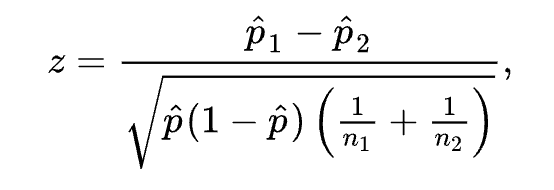

### Также выбирается уровень значимости α=0.05 и значение параметра β=0.2, мощность теста = (1-β).

## Определение MDE, длительности теста и размера выборки
### Размером выборки подразумевается всё значение генеральной совокупности = 1900, чтобы снизить уровень MDE = X(довольно большое), и время проведения теста = X(довольно большое)

## Применение поправки Бенферони
### Для контроля ошибки первого рода используется поправка Бенферони. С учётом количества метрик m = 5, уровень значимости α'=α/m. Следовательно уровень значимости равен α'=0.01

## Сплитование трафика
### Пропорции сплитования трафика были выбраны 50/50, способом сплитования трафика была выбрана стратификация пользователей по их покупательной способности, то есть показателю RFM. Будем хэшировать пользователей по их id и сплитовать по hash+salt, чтобы не допускать перемешивания с другими тестами. Общее количество пользователей в генеральной совокупности = 1900, контрольная группа = 950, тестовая группа = 950. Контролируем однородность групп, по среднему GMV группы и количеству пользователей по RFM сегментам.